In [2]:
import osmnx as ox
import networkx as nx
import pandas as pd
from shapely.geometry import Point
from pathlib import Path


# 5.2 Load the graphs
G_bike = ox.load_graphml("../data/raw/bike_network.graphml")
G_walk = ox.load_graphml("../data/raw/walk_network.graphml")

# 5.2 Geocode each hub address to (lat, lon)
centrum_latlon = ox.geocode("Wal 6, Eindhoven, Netherlands")
blix_latlon    = ox.geocode("Ouverture 51, Eindhoven, Netherlands")
meer_latlon    = ox.geocode("Meerplein 20, Eindhoven, Netherlands")

# Convert to Shapely Points (x=lon, y=lat)
point_centrum = Point(centrum_latlon[1], centrum_latlon[0])
point_blix    = Point(blix_latlon[1], blix_latlon[0])
point_meer    = Point(meer_latlon[1], meer_latlon[0])

# 5.3 Find nearest nodes in each graph using ox.nearest_nodes (x=lon, y=lat)
hub_centrum_node_bike = ox.nearest_nodes(G_bike, point_centrum.x, point_centrum.y)
hub_blix_node_bike    = ox.nearest_nodes(G_bike, point_blix.x, point_blix.y)
hub_meer_node_bike    = ox.nearest_nodes(G_bike, point_meer.x, point_meer.y)

hub_centrum_node_walk = ox.nearest_nodes(G_walk, point_centrum.x, point_centrum.y)
hub_blix_node_walk    = ox.nearest_nodes(G_walk, point_blix.x, point_blix.y)
hub_meer_node_walk    = ox.nearest_nodes(G_walk, point_meer.x, point_meer.y)

# 5.4 Store them in a DataFrame
hub_nodes_df = pd.DataFrame({
    "hub": ["Centrum", "Blixembosch", "Meerhoven"],
    "bike_node": [hub_centrum_node_bike, hub_blix_node_bike, hub_meer_node_bike],
    "walk_node": [hub_centrum_node_walk, hub_blix_node_walk, hub_meer_node_walk]
})
hub_nodes_df

Path("../data/processed").mkdir(parents=True, exist_ok=True)
# 5.5 Save to CSV
hub_nodes_df.to_csv("../data/processed/hub_nodes.csv", index=False)


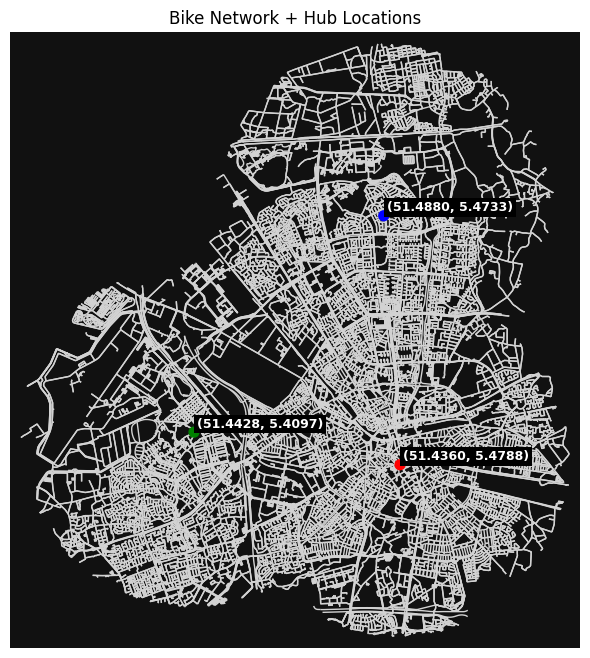

In [3]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import osmnx as ox


hub_points = gpd.GeoDataFrame(
    hub_nodes_df.assign(
        longitude=[
            float(G_bike.nodes[hub_centrum_node_bike]['x']),
            float(G_bike.nodes[hub_blix_node_bike]['x']),
            float(G_bike.nodes[hub_meer_node_bike]['x'])
        ],
        latitude=[
            float(G_bike.nodes[hub_centrum_node_bike]['y']),
            float(G_bike.nodes[hub_blix_node_bike]['y']),
            float(G_bike.nodes[hub_meer_node_bike]['y'])
        ]
    ),
    geometry=gpd.points_from_xy(
        [
            float(G_bike.nodes[hub_centrum_node_bike]['x']),
            float(G_bike.nodes[hub_blix_node_bike]['x']),
            float(G_bike.nodes[hub_meer_node_bike]['x']),
        ],
        [
            float(G_bike.nodes[hub_centrum_node_bike]['y']),
            float(G_bike.nodes[hub_blix_node_bike]['y']),
            float(G_bike.nodes[hub_meer_node_bike]['y']),
        ]
    ),
    crs="EPSG:4326"
)

fig, ax = ox.plot_graph(
    G_bike,
    show=False,
    close=False,
    node_size=0,
    edge_color="lightgray"
)
hub_points.plot(
    ax=ax,
    color=["red", "blue", "green"],
    markersize=50,
    zorder=3
)
ax.set_title("Bike Network + Hub Locations")


for idx, row in hub_points.iterrows():
    x = row.geometry.x
    y = row.geometry.y
    label = f"({y:.4f}, {x:.4f})"
    ax.text(
        x + 0.001,    # shift slightly right
        y + 0.001,    # shift slightly up
        label,
        fontsize=9,
        fontweight="bold",
        color="white",
        bbox={"facecolor": "black", "edgecolor": "none", "pad": 2},
        zorder=4
    )

plt.show()
